In [ ]:
!pip install -q Pillow opencv-python numpy matplotlib imagehash scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 1.5 MB/s eta 0:00:00


In [ ]:
import io
import cv2
import imagehash
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [ ]:
def compare_images_ssim(image_path1, image_path2):
    # Load images
    image1 = cv2.imread(image_path1)
    image2 = cv2.imread(image_path2)

    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Compute structural similarity index
    similarity_index, _ = ssim(image1, image2, full=True)

    return similarity_index

In [ ]:
def compare_images(image_path1, image_path2):
    # Load images
    image1 = cv2.imread(image_path1)
    image2 = cv2.imread(image_path2)

    # Convert BGR to HSV for color-based segmentation
    hsv_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2HSV)
    hsv_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds of the color you want to segment
    lower_bound = np.array([0, 0, 0])
    upper_bound = np.array([255, 255, 255])

    # Threshold the images to get only the specified color range
    mask1 = cv2.inRange(hsv_image1, lower_bound, upper_bound)
    mask2 = cv2.inRange(hsv_image2, lower_bound, upper_bound)

    # Bitwise-AND mask and original images
    segmented_image1 = cv2.bitwise_and(image1, image1, mask=mask1)
    segmented_image2 = cv2.bitwise_and(image2, image2, mask=mask2)

    # Use ORB for feature matching
    orb = cv2.ORB_create()

    # Find keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(segmented_image1, None)
    kp2, des2 = orb.detectAndCompute(segmented_image2, None)

    # Create BFMatcher (Brute Force Matcher)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)

    # Sort them in ascending order of distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw matches on the segmented images
    matching_image = cv2.drawMatches(segmented_image1, kp1, segmented_image2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Display the result
    # cv2.imshow('Matching Result', matching_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # Calculate similarity score
    similarity_score = len(matches)

    # Calculate percentage similarity based on the total number of keypoints
    total_keypoints = max(len(kp1), len(kp2))
    percentage_similarity = (similarity_score / total_keypoints) * 100

    # Print and return the results
    print(f"Similarity Score: {similarity_score}")
    print(f"Percentage Similarity: {percentage_similarity:.2f}%")

    plt.imshow(matching_image)
    plt.axis("off")
    plt.show()


In [ ]:
def compare_images_shifted_objects(image_path1, image_path2):
    # Load images
    image1 = cv2.imread(image_path1)
    image2 = cv2.imread(image_path2)

    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Create SIFT detector
    sift = cv2.SIFT_create()

    # Find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    # Create BFMatcher (Brute Force Matcher)
    bf = cv2.BFMatcher()

    # Match descriptors
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Draw matches on the images
    matching_image = cv2.drawMatches(image1, kp1, image2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Use RANSAC to find homography
    if len(good_matches) > 4:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        h, w = gray1.shape
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

        # Transform the corners using the homography matrix
        dst = cv2.perspectiveTransform(pts, H)

        # Draw the bounding box on the second image
        image2_with_box = cv2.polylines(image2, [np.int32(dst)], True, (0, 255, 0), 3)

        # Print and return the results
        print(f"Number of Good Matches: {len(good_matches)}")

        # Calculate similarity score
        similarity_score = len(matches)

        # Calculate percentage similarity based on the total number of keypoints
        total_keypoints = max(len(kp1), len(kp2))
        percentage_similarity = (similarity_score / total_keypoints) * 100

        # Print and return the results
        print(f"Similarity Score: {similarity_score}")
        print(f"Percentage Similarity: {percentage_similarity:.2f}%")


        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
        plt.title('Image 1')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
        plt.title('Image 2')
        plt.axis('off')

        """plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(image2_with_box, cv2.COLOR_BGR2RGB))
        plt.title('Matching Objects (with Box)')
        plt.axis('off')"""

        plt.show()
    else:
        print("Not enough matches found.")



Similarity Score: 180
Percentage Similarity: 37.97%


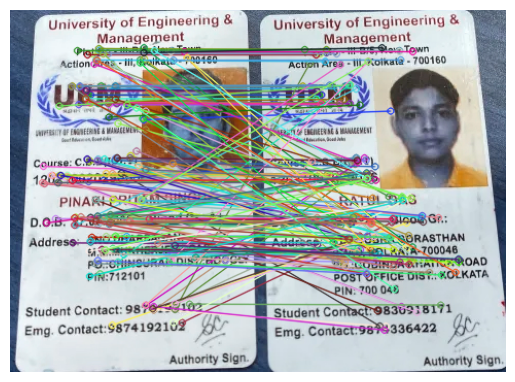

Number of Good Matches: 289
Similarity Score: 908
Percentage Similarity: 91.53%


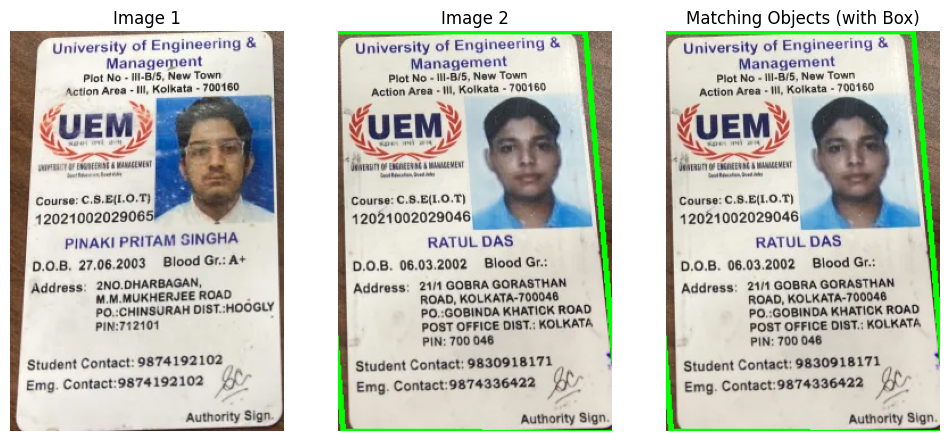

In [ ]:
compare_images('5.jpg', '6.jpg')
compare_images_shifted_objects('5.jpg', '6.jpg')

Similarity Score: 197
Percentage Similarity: 39.40%


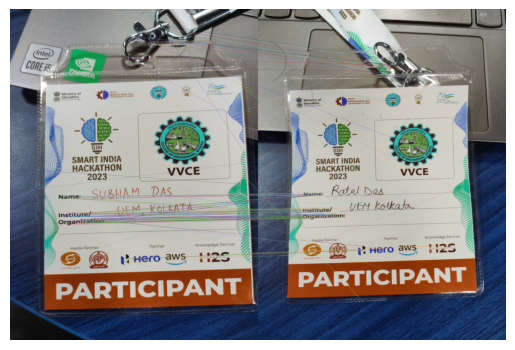

Number of Good Matches: 2391
Similarity Score: 27868
Percentage Similarity: 100.00%


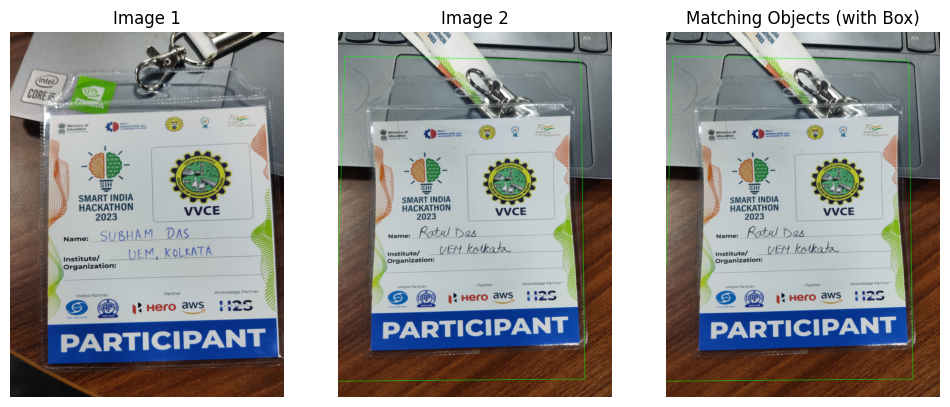

In [ ]:
compare_images('1.jpg', '2.jpg')
compare_images_shifted_objects('1.jpg', '2.jpg')

Similarity Score: 243
Percentage Similarity: 48.60%


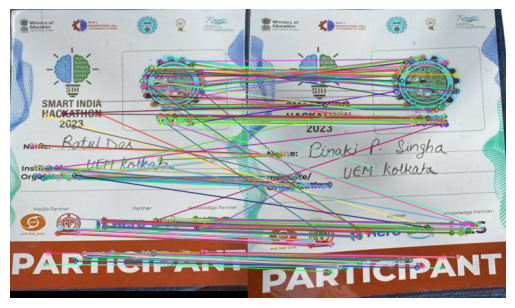

Number of Good Matches: 486
Similarity Score: 993
Percentage Similarity: 85.97%


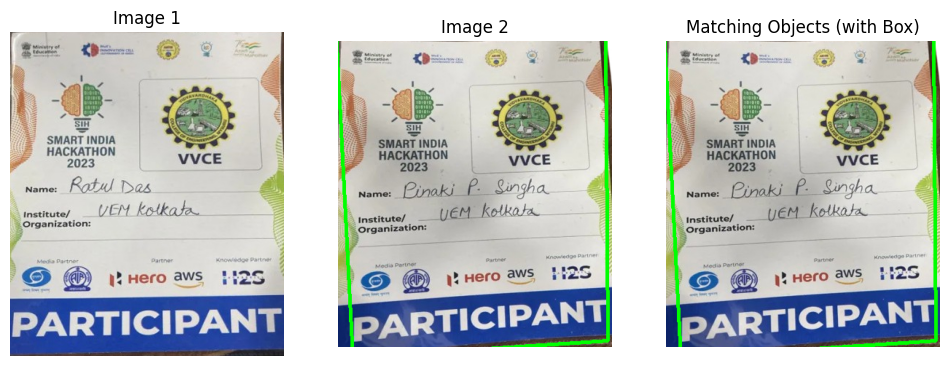

In [ ]:
compare_images('3.jpg', '4.jpg')
compare_images_shifted_objects('3.jpg', '4.jpg')

Similarity Score: 78
Percentage Similarity: 15.60%


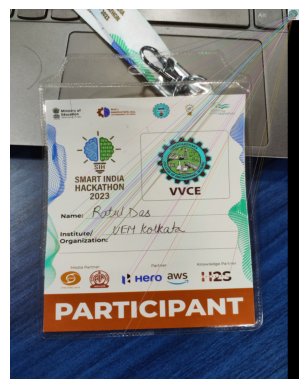

Number of Good Matches: 352
Similarity Score: 26555
Percentage Similarity: 100.00%


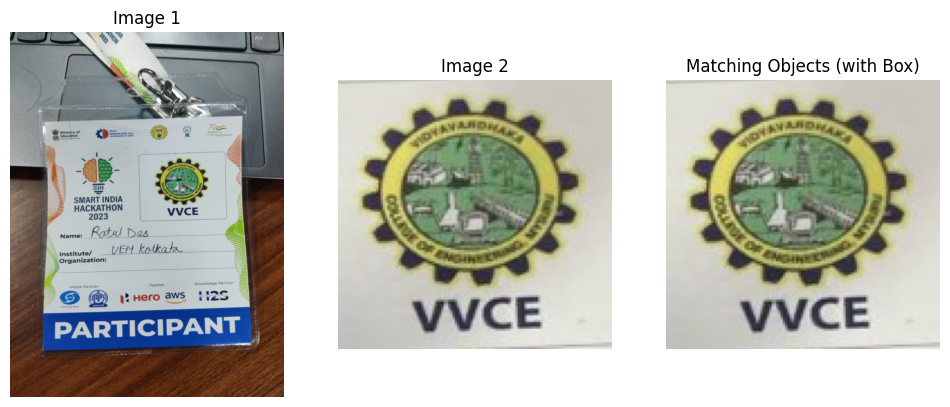

In [ ]:
compare_images('2.jpg', '7.jpg')
compare_images_shifted_objects('2.jpg', '7.jpg')

Similarity Score: 134
Percentage Similarity: 26.80%


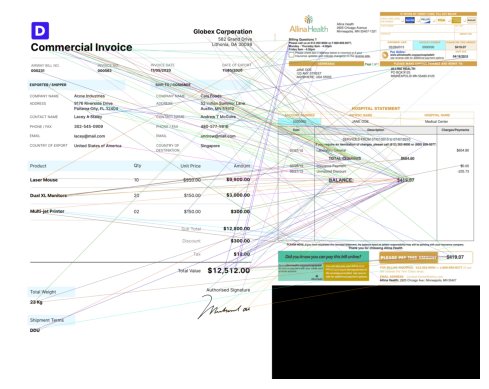

Number of Good Matches: 612
Similarity Score: 6197
Percentage Similarity: 52.37%


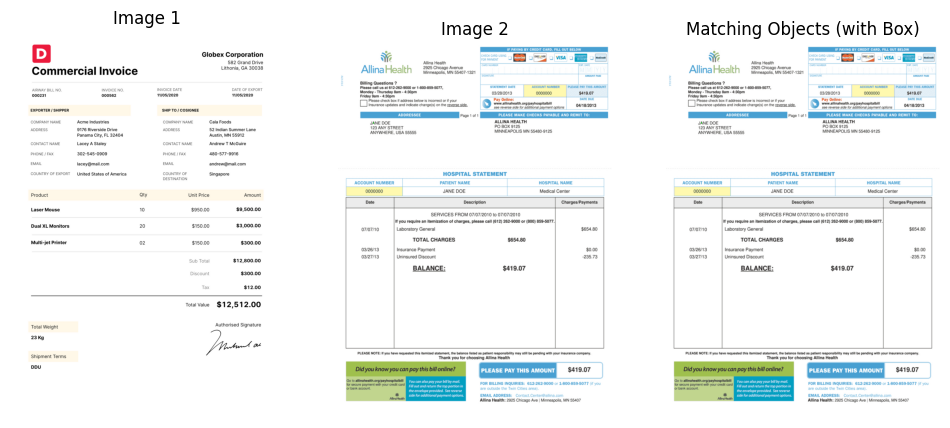

In [ ]:
compare_images('invoice3.png', 'medic22.jpg')
compare_images_shifted_objects('invoice3.png', 'medic22.jpg')

Similarity Score: 128
Percentage Similarity: 25.60%


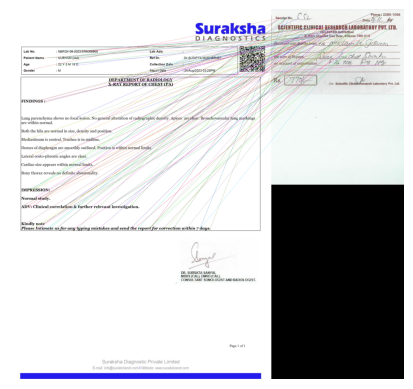

Number of Good Matches: 339
Similarity Score: 10782
Percentage Similarity: 100.00%


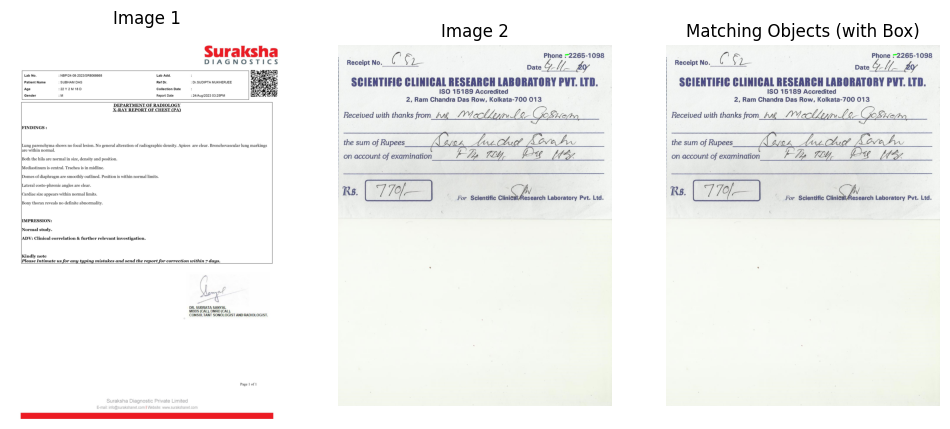

In [ ]:
compare_images('report.jpg', 'inovo.jpg')
compare_images_shifted_objects('report.jpg', 'inovo.jpg')